# Summary
In this notebook I classify images of hand-written digits from MNIST data set. These are the implemented steps to perform the classification:
1. Load data and explore data.
***
2. Data prepration.
    1. Split the train dataset into train and validation (dev) sets.
    2. Scale the pixel intensities in all train and test data down to the 0-1 range and convert them to floats.
***
3. Train a deep Multi Layer Perceptron (MLP) NN.
***
4. To improve the model (goal is 98% accuracy) perform hyper parameter tuning with the focus on learning rate. Use the approach in Chapter 10 of "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems". The approach is to increase the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up.
    1. Created a call back that inherits from keras.callbacks.callback that gradually increases learning rate.
    2. Passed the callback to the model
    3. ran model for one epoch and plotted the callback saved loss values vs. saved rate values.
    4. Picked the best learning rate (half of the value when the loss started to go up again)
***
4. Using the learning rate found in step 2, created a model and 
    1. passed a callback to it for tensorboard (keras.callbacks.TensorBoard)
    2. passed a callback for early stopping (keras.callbacks.EarlyStopping)
    3. passed a calleback to save the best model during the training process(keras.callbacks.ModelCheckPoint)
***
Lessons learned:
* Restart the session before any run!!! otherwise there are gonna be some problems.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Loading and Exploring Data

In [2]:
(X_train_all, y_train_all), (X_test, y_test )= keras.datasets.mnist.load_data()

In [3]:
X_train_all.shape

(60000, 28, 28)

In [4]:
X_test.shape

(10000, 28, 28)

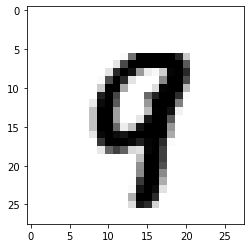

In [5]:
plt.imshow(X_train_all[800,:], cmap="binary")

# Data Prepration

A. Splitting train set into train and validation sets. I could simply use indexes to perform this task but I prefered to use the sklearn library for the sake of practicing. 

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, train_size=0.95, random_state = 42)

In [7]:
X_train.shape

(57000, 28, 28)

In [8]:
y_valid.shape

(3000,)

In [9]:
X_valid.shape

(3000, 28, 28)

In [10]:
y_valid.shape

(3000,)

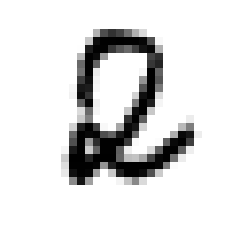

In [11]:
plt.imshow(X_valid[10,:], cmap="binary")
plt.axis('off')
plt.show()

B. Feature Scaling (Standardization)

In [12]:
X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test/255.0

# Building the MLP Model

Lets build a deep network with 2 hidden layers, 1 output and 1 input layer.

In [13]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28,28]))
model.add(keras.layers.Dense(300, activation = "relu"))
model.add(keras.layers.Dense(100, activation = "relu"))
model.add(keras.layers.Dense(10, activation = "softmax"))

In [15]:
model.compile(loss= keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.001),
              metrics=["accuracy"])

In [16]:
history = model.fit(X_train, y_train, epochs = 30, validation_data = (X_valid, y_valid))

Epoch 1/30
1782/1782 [==============================] - 4s 2ms/step - loss: 2.0816 - accuracy: 0.3267 - val_loss: 1.2279 - val_accuracy: 0.7710
Epoch 2/30
1782/1782 [==============================] - 3s 2ms/step - loss: 1.0264 - accuracy: 0.8080 - val_loss: 0.7050 - val_accuracy: 0.8400
Epoch 3/30
1782/1782 [==============================] - 3s 2ms/step - loss: 0.6359 - accuracy: 0.8525 - val_loss: 0.5402 - val_accuracy: 0.8647
Epoch 4/30
1782/1782 [==============================] - 4s 2ms/step - loss: 0.5063 - accuracy: 0.8713 - val_loss: 0.4643 - val_accuracy: 0.8740
Epoch 5/30
1782/1782 [==============================] - 3s 2ms/step - loss: 0.4356 - accuracy: 0.8868 - val_loss: 0.4211 - val_accuracy: 0.8807
Epoch 6/30
1782/1782 [==============================] - 3s 2ms/step - loss: 0.3995 - accuracy: 0.8938 - val_loss: 0.3917 - val_accuracy: 0.8867
Epoch 7/30
1782/1782 [==============================] - 3s 2ms/step - loss: 0.3797 - accuracy: 0.8952 - val_loss: 0.3713 - val_accuracy:

### Visualizing learning curves

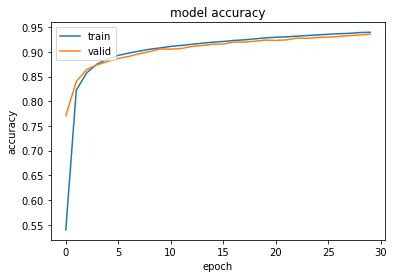

In [17]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

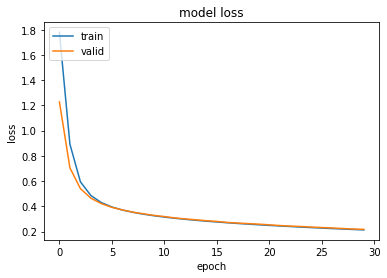

In [18]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [19]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 728us/step - loss: 0.2093 - accuracy: 0.9409


[0.20930759608745575, 0.9409000277519226]


As show above, the accuracy is relatively low and did not reach our goal (98%). Let's try hyper parameter tuning to increase accuracy.

# Searching for the best learning rate

In [20]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28,28]))
model.add(keras.layers.Dense(300, activation = "relu"))
model.add(keras.layers.Dense(100, activation = "relu"))
model.add(keras.layers.Dense(10, activation = "softmax"))

In [22]:
model.compile(loss= keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.001),
              metrics=["accuracy"])

In [23]:
K = keras.backend
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [24]:
exponentialLRCallBack = ExponentialLearningRate(1.005)

In [25]:
history = model.fit(X_train, y_train, epochs = 1, validation_data = (X_valid, y_valid),
                    callbacks=[exponentialLRCallBack])

1782/1782 [==============================] - 4s 2ms/step - loss: nan - accuracy: 0.4987 - val_loss: nan - val_accuracy: 0.0977


Text(0, 0.5, 'Loss')

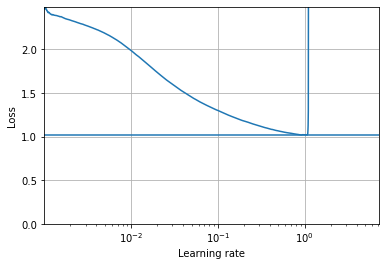

In [26]:
plt.plot(exponentialLRCallBack.rates, exponentialLRCallBack.losses)
plt.gca().set_xscale('log')
plt.hlines(min(exponentialLRCallBack.losses), min(exponentialLRCallBack.rates), max(exponentialLRCallBack.rates))
plt.axis([min(exponentialLRCallBack.rates), max(exponentialLRCallBack.rates), 0, exponentialLRCallBack.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

It looks like it starts to go up between 1e-1 and 10. So we clear the session and run the model with lr = 3e-1

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28,28]))
model.add(keras.layers.Dense(300, activation = "relu"))
model.add(keras.layers.Dense(100, activation = "relu"))
model.add(keras.layers.Dense(10, activation = "softmax"))

In [29]:
model.compile(loss= keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=3e-1),
              metrics=["accuracy"])

In [30]:
# tensorboard call back
import os

run_index = 5 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir
tensorboardCb = keras.callbacks.TensorBoard(run_logdir)

In [31]:
# Saving the best model call back
saveBestCb = keras.callbacks.ModelCheckpoint("Classification_MNIST_best.h5", save_best_only=True)

In [32]:
history = model.fit(X_train, y_train, epochs = 30, validation_data = (X_valid, y_valid),
                   callbacks=[keras.callbacks.EarlyStopping(patience=20),
                             tensorboardCb,
                             saveBestCb])

Epoch 1/30
1782/1782 [==============================] - 4s 2ms/step - loss: 0.3998 - accuracy: 0.8745 - val_loss: 0.1285 - val_accuracy: 0.9630
Epoch 2/30
1782/1782 [==============================] - 4s 2ms/step - loss: 0.0938 - accuracy: 0.9700 - val_loss: 0.0852 - val_accuracy: 0.9747
Epoch 3/30
1782/1782 [==============================] - 4s 2ms/step - loss: 0.0611 - accuracy: 0.9805 - val_loss: 0.0844 - val_accuracy: 0.9750
Epoch 4/30
1782/1782 [==============================] - 4s 2ms/step - loss: 0.0448 - accuracy: 0.9854 - val_loss: 0.0718 - val_accuracy: 0.9750
Epoch 5/30
1782/1782 [==============================] - 4s 2ms/step - loss: 0.0331 - accuracy: 0.9890 - val_loss: 0.0740 - val_accuracy: 0.9787
Epoch 6/30
1782/1782 [==============================] - 4s 2ms/step - loss: 0.0250 - accuracy: 0.9918 - val_loss: 0.1041 - val_accuracy: 0.9723
Epoch 7/30
1782/1782 [==============================] - 4s 2ms/step - loss: 0.0243 - accuracy: 0.9925 - val_loss: 0.0705 - val_accuracy:

In [33]:
model = keras.models.load_model("Classification_MNIST_best.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 792us/step - loss: 0.0755 - accuracy: 0.9803


[0.07547134906053543, 0.9803000092506409]

In [34]:
%load_ext tensorboard
%tensorboard --logdir=./my_mnist_logs --port=6008

Reusing TensorBoard on port 6008 (pid 81223), started 0:33:14 ago. (Use '!kill 81223' to kill it.)